# Pytorch Tutoral - Autograd & MLP(Multi-layer perceptron)
## Autograd
- autograd패키지는 텐서의 모든 연산에 대한 자동 미분을 제공
- 실행-기반-정의(define-by-run) 프레임워크로, 코드를 어떻게 작성하여 실행하느냐에 따라 역전파가 정의된다는 것을 의미
- 역전파는 학습 과정의 매 단계마다 달라짐
## Tensor
- torch.Tensor 클래스의 **.requires_grad 속성을 True로 설정**하면, 해당 텐서에서 이루어진 모든 연산을 추적(track)하기 시작
- 계산이 완료된 후 .backward()를 호출하여 모든 변화도(gradient)를 자동으로 계산할 수 있으며 이 Tensor의 변화도는 .grad 속성에 누적됨
- Tensor가 기록을 추적하는 것을 중단하게 하려면, .detach()를 호출하여 연산기록으로부터 분리하여 연산이 추적되는 것을 방지할 수 있음
- 기록을 추적하는 것(과 메모리를 사용하는 것)을 방지하기 위해서 코드 블럭을 with torch.no_grad():로 감쌀 수 있음
- 이는 변화도(gradient)는 필요 없지만 requires_grad=True가 설정되어 학습 가능한 매개변수를 갖는 모델을 평가(evaluate)할 때 유용
- Autograd 구현에서 Function 클래스는 매우 중요한 역할을 수행
- Tensor와 Function은 서로 연결되어 있고 모든 연산 과정을 부호화하여 순환하지 않는 그래프를 생성
- 각 tensor는 .grad_fn 속성을 가지고 있는데 이는 Tensor를 생성한 Function을 참조함(단, 사용자가 만든 Tensor는 예외이며, 사용자가 만든 Tensor가 아닌 연산에 의해 생긴 텐서와 같은 경우는 모두 Function을 참조)
- 도함수를 계산하기 위해서는 Tensor의 .backward()를 호출하면 됨

In [1]:
# 위의 내용들을 직접 실습해보자

import torch

In [2]:
# x의 연산 과정을 추적하기 위해 requires_grad=True로 설정
x = torch.ones(2, 2, requires_grad=True)
print(x)

# 직접 생선한 Tensor이기 때문에 grad_fn이 None인 것을 확인할 수 있음
print(x.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


In [3]:
# y는 연산의 결과로 생성된 것이기 때문에 grad_fn을 갖고 있는 것을 확인 가능
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [4]:
# 연산의 결과로 생성된 것이기 때문에 grad_fn을 갖는 것을 확인 가능
print(y.grad_fn)

In [5]:
z = y * y * 3
out = z.mean()

# 각각 사용한 func에 맞게 grad_fn이 생성된 것을 확인할 수 있음
print(z)
print(out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)
tensor(27., grad_fn=<MeanBackward0>)


- requires_grad_()를 사용하면 기존 Tensor의 requires_grad 값을 바꿀 수 있음
- 입력 값이 지정되지 않으면 기본 값은 False

In [6]:
a = torch.randn(2, 2)
print(a)

tensor([[-0.4515, -0.8731],
        [-2.2938,  0.4496]])


In [7]:
a = ((a * 3) / (a - 1))
print(a)
print(a.requires_grad) # default 값인 False

tensor([[ 0.9331,  1.3984],
        [ 2.0892, -2.4505]])
False


In [8]:
a.requires_grad_(True) # requires_grad 속성을 True로

tensor([[ 0.9331,  1.3984],
        [ 2.0892, -2.4505]], requires_grad=True)

In [9]:
print(a.requires_grad)

True


In [10]:
b = (a * a).sum()
print(b)
print(b.requires_grad)

tensor(13.1959, grad_fn=<SumBackward0>)
True


# 변화도

In [11]:
print(out)

# 이전에 만든 out을 사용해서 역전파 진행

y.retain_grad()     # 중간 값에 대한 미분 값을 보고싶다면 해당 값에 대한 retain_grad()를 호출해야 함
z.retain_grad()     # 중간 값에 대한 미분 값을 보고싶다면 해당 값에 대한 retain_grad()를 호출해야 함
out.backward()      # 여러 번 미분을 진행하기 위해서는 retain_graph=True로 설정해줘야 함(그렇지 않으면 아래처럼 에러 발생)

# out.backward(torch.tensor(1.))을 진행하는 것과 동일
print(x.grad)
print(y.grad)
print(z.grad)
print(z.is_leaf) # 찾아보기

out.backward()
print(x.grad)
print(y.grad)

tensor(27., grad_fn=<MeanBackward0>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])
False


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [12]:
x = torch.ones(2, 2, requires_grad=True) # True로 설정하여 런타임 에러 방지
y = x + 2
z = y * y * 3
out = z.mean()

print(out)

y.retain_grad()
out.backward(retain_graph=True) # True로 설정하여 런타임 에러 방지

print(x.grad)
print(y.grad)
print(z.grad)       # z.retain_grad()를 호출하지 않으면 grad값을 저장하지 않기 때문에 grad 속성을 볼 수 없음
print(z.is_leaf)

out.backward()
print(x.grad)
print(y.grad)

tensor(27., grad_fn=<MeanBackward0>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
None
False
tensor([[9., 9.],
        [9., 9.]])
tensor([[9., 9.],
        [9., 9.]])


C:\Users\user\anaconda3\lib\site-packages\torch\_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:482.)
  return self._grad


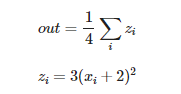


- z_i를 미분한 값에 적용하면 4.5를 동일하게 출력할 수 있음
out(미분결과) = 1/4 6 (x + 2) = 3/2(x+2)
---

- 일반적으로 torch.autograd는 벡터-야코비안 곱을 계산하는 엔진
- torch.autograd를 사용하면 전체 야코비안을 직접 계산할 수는 없지만, 벡터-야코비안 곱은 backward에 해당 벡터를 인자로 제공하여 얻을 수 있음

In [13]:
x = torch.randn(3, requires_grad=True)

y = x * 2

while y.data.norm() < 1000:
  y = y * 2

print(y)

tensor([ 504.3647, -555.9961,  728.6607], grad_fn=<MulBackward0>)


In [14]:
# scalar값이 아닌 y의 벡터-야코비안 곱을 구하는 과정
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v) # backward 진행

print(x.grad) # 미분 후 값이 나옴

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


- with torch.no_grad()로 코드 블록을 감싸서 autograd가 .requires_grad=True인 Tensor의 연산 기록을 추적하는 것을 멈출 수도 있음

In [15]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
  print((x ** 2).requires_grad) # 연산 기록을 추적하는 것을 멈추기 위함이기 때문에, requires_grad 속성값이 모두 false

True
True
False


- 또는 .detach()를 호출하여 내용물은 같지만 requires_grad가 다른 새로운 텐서를 가져올 수 있음

In [16]:
print(x.requires_grad)
y = x.detach() # requires_grad 속성값이 다름
print(y.requires_grad)
print(x.eq(y).all())

True
False
tensor(True)


# ANN(Artificial Neural Networks)

- 신경망은 torch.nn 패키지를 사용하여 생성할 수 있음
- nn은 모델을 정의하고 미분하기 위해서 위에서 살펴본 autograd를 사용
- nn.Module은 계층(layer)과 output을 반환하는 forward(input) 메소드를 포함

---

- 간단한 순전파 네트워크(feed-forward-network)
- 입력을 받아 여러 계층에 차례로 전달한 후, 최종 출력을 제공
- 신경망의 일반적인 학습 과정
>- 학습 가능한 매개변수(가중치)를 갖는 신경망을 정의
>- 데이터 셋 입력을 반복
>- 입력을 신경망에서 전파(process)
>- 손실(loss; 입력 값과 예측 값과의 차이)를 계산
>- 변화도(gradient)를 신경망의 매개변수들에 역으로 전파 - 역전파 과정
>- 신경망의 가중치를 갱신
>>- 새로운 가중치(weight) = 가중치(weight) - 학습률(learning rate) * 변화도(gradient)

In [17]:
import pandas as pd

from sklearn.datasets import load_iris

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [18]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer0 = nn.Linear(4, 128) # 선형함수
        self.layer1 = nn.Linear(128, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 3)

        self.bn0 = nn.BatchNorm1d(128) # 양극단으로 튀지 않도록 정규화
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)

        self.act = nn.ReLU() # 비선형함수

    def forward(self, x):
      x = self.act(self.bn0(self.layer0(x)))
      x = self.act(self.bn1(self.layer1(x)))
      x = self.act(self.bn2(self.layer2(x)))
      x = self.act(self.layer3(x))
      x = self.layer4(x)

      return x

# 손실 함수(Loss Function)
- 손실 함수는 (output, target)을 한 쌍으로 입력 받아, 출력이 정답으로부터 얼마나 떨어져있는지 추정하는 값을 계산


- forward함수만 정의하고 나면 backward함수는 autograd를 사용하여 자동으로 정의됨
- 모델의 학습 가능한 매개 변수는 net.parameters()에 의해 변환됨

In [19]:
# 랜덤 값 생성
criterion = nn.CrossEntropyLoss() # 다중분류모델을 사용

ex_X, ex_y = torch.randn([4, 4]), torch.tensor([1, 0, 2, 0])

net = Net()
output = net(ex_X)
loss = criterion(output, ex_y)
print('loss: ', loss.item()) # 오차값
  
net.zero_grad()

print('layer0.bias.grad before backward') 
print(net.layer4.bias.grad) #그래디언트가 초기화된 상태여서 None
print(net.layer4.bias.is_leaf) # 링크 참고

loss.backward()

print('layer0.bias.grad after backward')
print(net.layer4.bias.grad) # 그래디언트가 생성된 것을 확인 가능

"""
이 부분에서 .retain_grad() 를 사용하지 않아도 되는 이유는 weight와 bias의 파라미터가 leaf 노드이기 때문이라고 합니다.
설명이 포함된 링크들을 아래에 첨부해두니 읽어보시면 좋을 것 같습니다 :)

어떤 경우가 leaf 노드 인지 - https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/20
왜 leaf 노드인 경우에는 retain_grad()를 하지 않아도 grad 값이 나오는지 - https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/7
"""

loss:  1.0722663402557373
layer0.bias.grad before backward
None
True
layer0.bias.grad after backward
tensor([-0.1083,  0.0300,  0.0782])


'\n이 부분에서 .retain_grad() 를 사용하지 않아도 되는 이유는 weight와 bias의 파라미터가 leaf 노드이기 때문이라고 합니다.\n설명이 포함된 링크들을 아래에 첨부해두니 읽어보시면 좋을 것 같습니다 :)\n\n어떤 경우가 leaf 노드 인지 - https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/20\n왜 leaf 노드인 경우에는 retain_grad()를 하지 않아도 grad 값이 나오는지 - https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/7\n'

In [20]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # layer0의 가중치값

16
torch.Size([128, 4])


# 가중치 갱신
- 가장 단순한 갱신 규칙은 확률적 경사하강법(SGD; Stochastic Gradient Descent)
- 새로운 가중치(weight) = 가중치(weight) - 학습률(learning rate) * 변화도(gradient)

In [21]:
# torch.optim 패키지에 다양한 갱신 규칙이 규현되어 있음

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001)

optimizer.zero_grad()
output = net(ex_X)
loss = criterion(output, ex_y)
loss.backward()
optimizer.step()  # 업데이트 진행

# MLP 모델

In [22]:
dataset = load_iris() # load iris 사용. 꽃 데이터, 150개의 샘플, 4개의 속성

data = dataset.data
label = dataset.target

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [23]:
print('shape of data: ', data.shape) # 4개 속성
print('shape of label: ',label.shape) # 1개 라벨

shape of data:  (150, 4)
shape of label:  (150,)


In [24]:
# 훈련과 테스트 데이터로 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25) # 25%가 테스트 데이터 / 75%가 train 데이터
print(len(X_train))
print(len(X_test))

112
38


In [25]:
# DataLoader 생성
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

train_set = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True) # batch_size: 한번에 몇 개의 데이터를 볼건지를 정해줌. 

In [26]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer0 = nn.Linear(4, 128)
        self.layer1 = nn.Linear(128, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 3)

        self.bn0 = nn.BatchNorm1d(128)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)

        self.act = nn.ReLU()

    def forward(self, x):
      x = self.act(self.bn0(self.layer0(x)))
      x = self.act(self.bn1(self.layer1(x)))
      x = self.act(self.bn2(self.layer2(x)))
      x = self.act(self.layer3(x))
      x = self.layer4(x)

      return x
      # return nn.Softmax(x)

In [27]:
net = Net()
print(net) # 요소 확인 가능

Net(
  (layer0): Linear(in_features=4, out_features=128, bias=True)
  (layer1): Linear(in_features=128, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=3, bias=True)
  (bn0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
)


In [28]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001) #SGD 사용
criterion = nn.CrossEntropyLoss()
epochs = 200 # 200번 반복

In [29]:
losses = list()
accuracies = list()

for epoch in range(epochs):
  epoch_loss = 0  
  epoch_accuracy = 0
  for X, y in train_loader:
  
    optimizer.zero_grad() # 초기에 그래디언트 0으로 초기화
    
    output = net(X) # 모델에 입력값 넣어 예측값 얻음

    loss = criterion(output, y) # 예측값(output)과 정답값(y)을 사용해 오차를 구하기 
    loss.backward() # backward 진행
    
    optimizer.step()
    # output = [0.11, 0.5, 0.8]  --> 가장 큰 값(0.8)이 예측 클래스 값
    _, predicted = torch.max(output, dim=1)
    accuracy = (predicted == y).sum().item()
    epoch_loss += loss.item()
    epoch_accuracy += accuracy
  

  epoch_loss /= len(train_loader)
  epoch_accuracy /= len(X_train)
  print("epoch :{}, \tloss :{}, \taccuracy :{}".format(str(epoch+1).zfill(3),round(epoch_loss,4), round(epoch_accuracy,4)))
  
  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)

epoch :001, 	loss :1.1035, 	accuracy :0.3661
epoch :002, 	loss :1.102, 	accuracy :0.375
epoch :003, 	loss :1.0817, 	accuracy :0.4911
epoch :004, 	loss :1.0585, 	accuracy :0.5446
epoch :005, 	loss :1.043, 	accuracy :0.6161
epoch :006, 	loss :1.0519, 	accuracy :0.6071
epoch :007, 	loss :1.0402, 	accuracy :0.625
epoch :008, 	loss :1.0173, 	accuracy :0.6429
epoch :009, 	loss :1.023, 	accuracy :0.6607
epoch :010, 	loss :1.0023, 	accuracy :0.6429
epoch :011, 	loss :1.0134, 	accuracy :0.6339
epoch :012, 	loss :0.9782, 	accuracy :0.6518
epoch :013, 	loss :0.9744, 	accuracy :0.6518
epoch :014, 	loss :0.9579, 	accuracy :0.6518
epoch :015, 	loss :0.9503, 	accuracy :0.6696
epoch :016, 	loss :0.9784, 	accuracy :0.6339
epoch :017, 	loss :0.9659, 	accuracy :0.6607
epoch :018, 	loss :0.9792, 	accuracy :0.6339
epoch :019, 	loss :0.9686, 	accuracy :0.6161
epoch :020, 	loss :0.9603, 	accuracy :0.6607
epoch :021, 	loss :0.9339, 	accuracy :0.6429
epoch :022, 	loss :0.9383, 	accuracy :0.6607
epoch :023, 	lo

epoch :188, 	loss :0.4452, 	accuracy :0.8482
epoch :189, 	loss :0.4625, 	accuracy :0.8125
epoch :190, 	loss :0.4591, 	accuracy :0.8304
epoch :191, 	loss :0.3838, 	accuracy :0.8482
epoch :192, 	loss :0.4098, 	accuracy :0.8571
epoch :193, 	loss :0.3393, 	accuracy :0.8839
epoch :194, 	loss :0.413, 	accuracy :0.8304
epoch :195, 	loss :0.4323, 	accuracy :0.8661
epoch :196, 	loss :0.4555, 	accuracy :0.8304
epoch :197, 	loss :0.357, 	accuracy :0.875
epoch :198, 	loss :0.4367, 	accuracy :0.8482
epoch :199, 	loss :0.3911, 	accuracy :0.8482
epoch :200, 	loss :0.4372, 	accuracy :0.8214


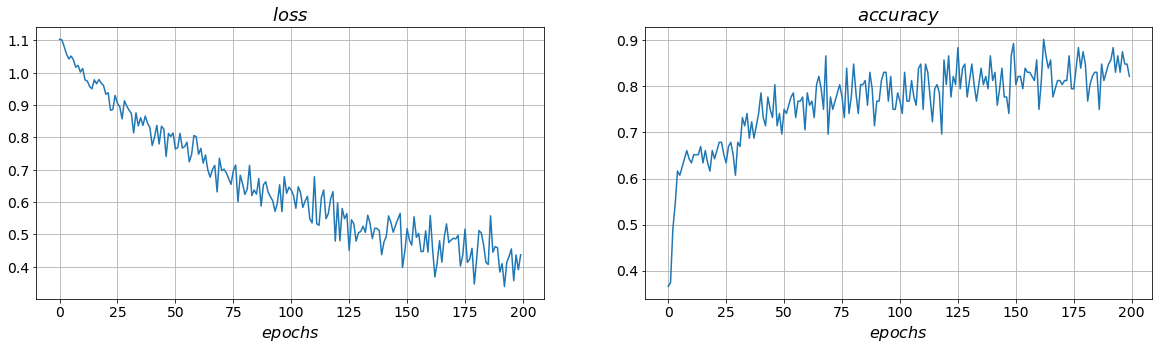

In [30]:
# Plot result

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)
plt.title("$loss$",fontsize = 18)
plt.plot(losses)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


plt.subplot(1,2,2)
plt.title("$accuracy$", fontsize = 18)
plt.plot(accuracies)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

In [31]:
# Test

output = net(X_test)
print(torch.max(output, dim=1))
_, predicted = torch.max(output, dim=1)
accuracy = round((predicted == y_test).sum().item() / len(y_test),4)


print("test_set accuracy :", round(accuracy,4))

torch.return_types.max(
values=tensor([1.8685, 1.4603, 2.3255, 2.4654, 1.5669, 2.0788, 3.0742, 1.3868, 1.4416,
        1.6119, 2.5837, 0.6237, 1.2343, 2.4366, 1.4199, 2.5164, 1.2726, 1.7799,
        1.2190, 0.5389, 1.1578, 1.0079, 2.5280, 1.5099, 2.3915, 0.6843, 2.2268,
        2.2888, 2.2537, 0.6279, 1.4639, 1.8957, 2.8840, 2.9323, 2.1205, 1.7671,
        3.0556, 1.2024], grad_fn=<MaxBackward0>),
indices=tensor([2, 1, 2, 0, 2, 0, 2, 1, 1, 2, 0, 2, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1,
        0, 1, 0, 0, 2, 2, 1, 1, 0, 0, 2, 1, 2, 2]))
test_set accuracy : 1.0


---

# 자동 미분과 그래디언트 테이프
## 그레디언트 테이프
- 텐서플로는 자동미분을 위한 tf.GradientTape API를 제공
- tf.GradientTape는 컨텍스트 안에서 실행된 모든 연산을 테이프에 '기록'
- 후진 방식 자동 미분(reverse mode differetiation)을 사용해서 테이프에 '기록된' 연산 그래디언트를 계산

In [32]:
import tensorflow as tf

print(tf.__version__)

2.9.1


In [33]:
x = tf.ones((2, 2))
# 1, 1
# 1, 1
with tf.GradientTape() as t:
  t.watch(x)
  y = tf.reduce_sum(x) # 이렇게 아무것도 넣지 않으면 전체 행렬에 들어있는 요소들의 합을 계산
  print('y: ', y)
  z = tf.multiply(y, y)
  print('z: ', z)

# 입력 텐서 x에 대한 z의 도함수
dz_dx = t.gradient(z, x)
print(dz_dx)
for i in [0, 1]:
  for j in [0, 1]:
    # AssertionError가 발생하지 않음
    assert dz_dx[i][j].numpy() == 8.0

y:  tf.Tensor(4.0, shape=(), dtype=float32)
z:  tf.Tensor(16.0, shape=(), dtype=float32)
tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


In [34]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
  t.watch(x)
  y = tf.reduce_sum(x)
  z = tf.multiply(y, y)

# tf.GradientTape() 안에서 계산된 중간 값에 대한 그래디언트도 구할 수 있습니다.
# 테이프 사용하여 중간값 y에 대한 도함수를 계산합니다. 
dz_dy = t.gradient(z, y)
assert dz_dy.numpy() == 8.0

- GradientTape.gradient() 메소드가 호출되면 GradientTape에 포함된 리소스가 해제됨
- 동일한 연산에 대해 여러 그래디언트를 계산하려면 지속성있는(persistent=True) 그래디언트 테이프를 생성하면 됨
- 이렇게 생성한 그래디언트 테이프틑 gradient() 메소드의 다중 호출을 허용

In [35]:
x = tf.constant(3.0)
with tf.GradientTape(persistent=True) as t:
  t.watch(x)
  y = x * x
  z = y * y  # z = x ^ 4
dz_dx = t.gradient(z, x)  # 108.0 (4*x^3 at x = 3)
print(dz_dx)
dy_dx = t.gradient(y, x)  # 6.0   (2 * x at x = 3)
print(dy_dx)
del t  # 반복해서 보기 때문에 테이프에 대한 참조를 삭제합니다.

tf.Tensor(108.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


# 제어 흐름 기록
- 연산이 실행되는 순서대로 테이프에 기록되기 때문에, 파이썬 제어흐름이 자연스럽게 처리됨

In [36]:
def f(x, y):
  output = 1.0
  for i in range(y):
    if i > 1 and i < 5:   # output(1) * 2 * 3 * 4
      output = tf.multiply(output, x)
  return output

def grad(x, y):
  with tf.GradientTape() as t:
    t.watch(x)
    out = f(x, y)
  return t.gradient(out, x)

x = tf.convert_to_tensor(2.0)

print(grad(x, 6).numpy())
assert grad(x, 6).numpy() == 12.0

print(grad(x, 5).numpy())
assert grad(x, 5).numpy() == 12.0

print(grad(x, 4).numpy())
assert grad(x, 4).numpy() == 4.0

# assertion error 발생 안함

12.0
12.0
4.0


# 고계도(Higher-order) 그래디언트
- GradientTape 컨텍스트 매니저 안에 있는 연산들은 자동미분을 위해 기록됨
- 만약 이 컨텍스트 안에서 그래디언트를 계산하면 해당 그래디언트 연산 또한 기록됨

In [37]:
x = tf.Variable(1.0) 

with tf.GradientTape() as t:
  with tf.GradientTape() as t2:
    y = x * x * x
  # 't' 컨텍스트 매니저 안의 그래디언트를 계산합니다.
  # 이것은 또한 그래디언트 연산 자체도 미분가능하다는 것을 의미합니다. 
  dy_dx = t2.gradient(y, x)      # dy_dx = 3 * x^2 at x = 1
d2y_dx2 = t.gradient(dy_dx, x)   # d2y_dx2 = 6 * x at x = 1

assert dy_dx.numpy() == 3.0
assert d2y_dx2.numpy() == 6.0


# GradientTape를 사용해서 미분이 이루어지는 연산과정을 추적할 수 있음 -> 텐서플로우와 토치의 다른점
# 텐서플로우와 토치의 공통점: 넘파이와 다르게 자동미분이 이루어짐

# ANN(Artificial Neural Network)

## Sequential 모델을 사용하는 경우

- Sequential 모델은 각 레이어에 정확히 하나의 입력 텐서와 하나의 출력 텐서가 있는 일반 레이어 스택에 적합

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [39]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),  # Pytorch - nn.Linear 
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
# [1, 1, 1] --> [o, o] --> [o, o, o] --> [o, o, o, o]
y = model(x)
print(y)

tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(3, 4), dtype=float32)


In [40]:
# Create 3 layers
# 위의 함수와 동일
# sequential 함수 사용 안함
layer1 = layers.Dense(2, activation="relu", name="layer1")
layer2 = layers.Dense(3, activation="relu", name="layer2")
layer3 = layers.Conv1D(4, name="layer3")

# Call layers on a test input
x = tf.ones((3, 3))
y = layer3(layer2(layer1(x)))
print(y) # y = w * x

TypeError: __init__() missing 1 required positional argument: 'kernel_size'

In [41]:
# layers 속성을 사용해서 레이어에 대해 접근할 수 있음
model.layers

In [42]:
# add() 메서드를 통해서 Sequential 모델을 점진적으로 작성할 수도 있음
model = keras.Sequential()
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

In [43]:
model.layers

In [44]:
# pop() 메서드를 사용하면 레이어를 제거할 수 있음
model.pop()
print(len(model.layers))  # 2

2


# 패션 MNIST를 사용한 분류 문제
- 패션 MNIST 데이터에는 10개의 카테고리와 70,000개의 흑백이미지가 포함
- 이미지의 해상도는 28*28
- 네트워크 훈련에 60,000개의 이미지를 사용하고, 평가를 위해 10,000개를 사용

In [45]:
# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.9.1


In [46]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [47]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [48]:
train_images.shape

(60000, 28, 28)

In [49]:
len(train_labels) #6만개

60000

In [50]:
# 각 라벨은 0~9 사이의 정수
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

# 데이터 전처리


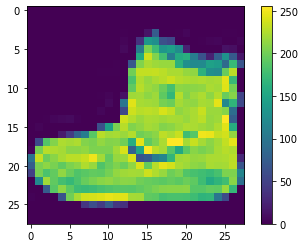

In [51]:
# 훈련 데이터의 첫번째 이미지
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [52]:
# 신경망 모델에 주입하기 전에 값의 범위를 0~1로 조정
train_images = train_images / 255.0

test_images = test_images / 255.0

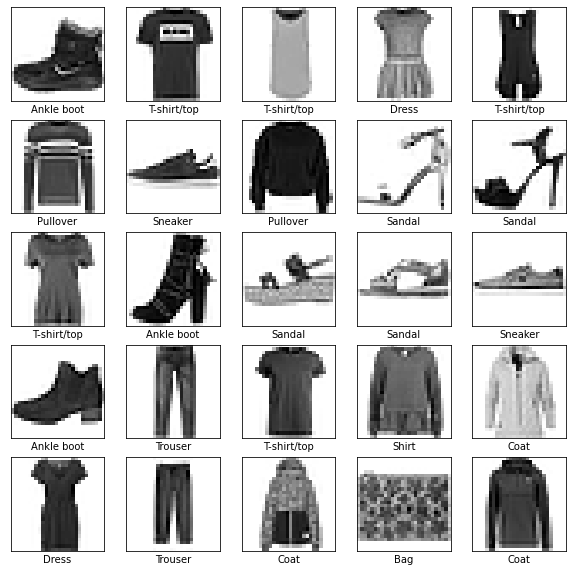

In [53]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# 모델 구성

In [54]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)), # Flatten: 행렬 -> 벡터로 바꿔줌
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [58]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [59]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [60]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [61]:
model.compile(optimizer='adam', # SGD, SGD + momentum 등등. adam이 주로 사용됨. 
              loss='sparse_categorical_crossentropy', #sparse_categorical_crossentropy: 예측값이 특정한 정수 값으로 나올 때 사용
              metrics=['accuracy']) # 정확도

In [62]:
model.fit(train_images, train_labels, epochs=5) #5번 반복 -> 정확도는 올라가고 오차는 줄어듦

Epoch 1/5
1875/1875 [==============================] - 2s 970us/step - loss: 0.5063 - accuracy: 0.8207
Epoch 2/5
1875/1875 [==============================] - 2s 944us/step - loss: 0.3781 - accuracy: 0.8637
Epoch 3/5
1875/1875 [==============================] - 2s 935us/step - loss: 0.3380 - accuracy: 0.8768
Epoch 4/5
1875/1875 [==============================] - 2s 948us/step - loss: 0.3137 - accuracy: 0.8851
Epoch 5/5
1875/1875 [==============================] - 2s 960us/step - loss: 0.2948 - accuracy: 0.8909


In [59]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print("Test loss:", test_loss)
print("Test accuracy:", test_acc) # 반복수를 늘리면 더 올라감

313/313 - 0s - loss: 0.3473 - accuracy: 0.8734 - 351ms/epoch - 1ms/step
Test loss: 0.34726282954216003
Test accuracy: 0.8733999729156494


In [60]:
# 훈련된 모델을 사용하여 이미지에 대한 예측 만들기
predictions = model.predict(test_images)

313/313 [==============================] - 0s 713us/step


In [61]:
# 테스트 세트에 있는 각 이미지에 대한 예측을 진행한 후, 첫번째 예측 값
# 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냄
predictions[0]

array([5.8762572e-07, 7.8301243e-10, 1.2174176e-07, 1.0637965e-07,
       1.3732607e-08, 2.6076509e-02, 7.3629252e-07, 1.3046078e-02,
       4.7958447e-06, 9.6087104e-01], dtype=float32)

In [62]:
# 가장 높은 신뢰도를 가진 레이블 출력
np.argmax(predictions[0])

9

In [63]:
# 실제 테스트 데이터의 0번째 값
test_labels[0]

9

In [64]:
# 10개의 클래스에 대한 예측을 모두 그래프로 표현
# 올바르게 예측된 레이블은 파란색으로, 잘못 예측된 레이블은 빨강색으로 표현
# 숫자는 예측 레이블의 신뢰도 퍼센트

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

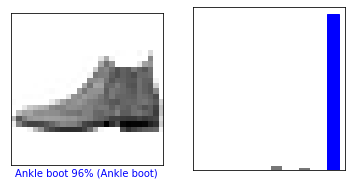

In [65]:
# 0번째 원소의 이미지, 예측, 신뢰도 점수 배열
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

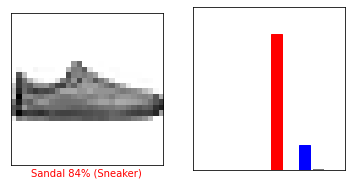

In [66]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

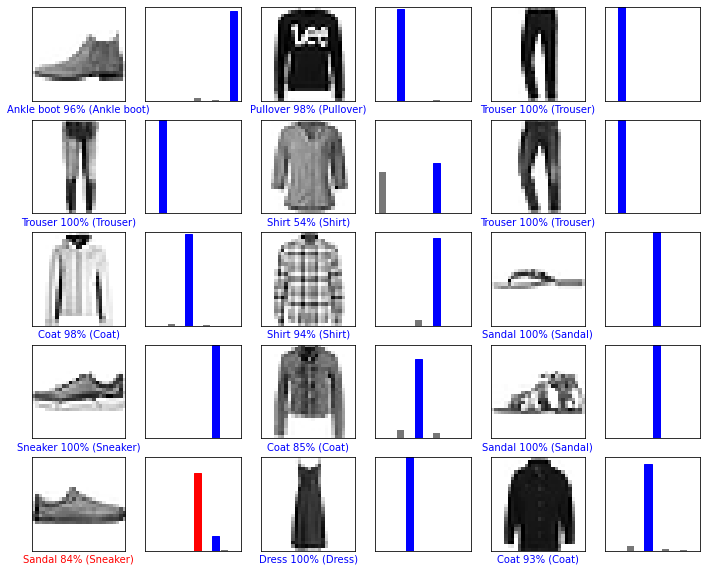

In [67]:
# 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()